In [3]:
import jax
from tinygp import kernels
from tinygp import GaussianProcess

import numpy as np
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

In [4]:
kernel = 0.5 * kernels.ExpSquared(scale=1.5)
DESI_2024_sigmaz_corr_pzbin1 = np.load('data/Fig1_Fig8_dr10_allfoot_perbin_sigmaz0.0500_dr6_corr_pzbin1.npz')

X=DESI_2024_sigmaz_corr_pzbin1['theta_arcmins']
y=DESI_2024_sigmaz_corr_pzbin1['prof']

gp = GaussianProcess(kernel, X, diag=1e-4)


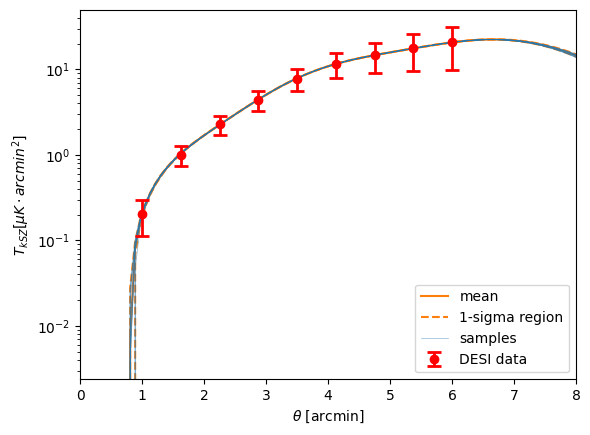

In [7]:
X_test = np.linspace(0, 8, 100)
_, cond_gp = gp.condition(y, X_test)

# The GP object keeps track of its mean and variance, which we can use for
# plotting confidence intervals
mu = cond_gp.mean
std = np.sqrt(cond_gp.variance)
plt.plot(X_test, mu, "C1", label="mean")
plt.plot(X_test, mu + std, "--C1", label="1-sigma region")
plt.plot(X_test, mu - std, "--C1")

# We can also plot samples from the conditional
y_samp = cond_gp.sample(jax.random.PRNGKey(1), shape=(12,))
plt.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
plt.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5)

plt.errorbar(DESI_2024_sigmaz_corr_pzbin1['theta_arcmins'], DESI_2024_sigmaz_corr_pzbin1['prof'], yerr=np.sqrt(DESI_2024_sigmaz_corr_pzbin1['cov'].diagonal()), color='r',
             fmt='o',capsize=5, capthick=2, linewidth=2, markersize=6, label="DESI data")
plt.legend(fontsize=10)
plt.xlim(X_test.min(), X_test.max())

plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$T_{kSZ} [\mu K \cdot arcmin^2]$')
plt.yscale('log')
plt.show()

# TRAINING...!

## Hyperparameter optimization for GP on mean profiles
- 2-Stage robust training: ✅ proved faster and same accuracy 
- find best kernel 
- make sure GPTrainer() runs ✅ 
- if kSZ data, only train on first 10 bins (R<3 Mpc)
- Pk only use k<10c/Mpc: ✅  no change and faster 
- train with or without validation data

In [3]:
import importlib
import src.models.kernels
importlib.reload(src.models.kernels) 
from src.models.kernels import *
import src.data.sim_dataloader
importlib.reload(src.data.sim_dataloader) 
import src.models.gp_trainer
importlib.reload(src.models.gp_trainer) 
from src.models.gp_trainer import *

# Initialize trainer with simulation indices and configuration
trainer = GPTrainer(
    sim_indices_total=np.arange(1024).tolist(),
    train_test_val_split=(0.7, 0.2, 0.1),
    filterType='CAP',
    ptype='gas'
)



JAX devices: [CpuDevice(id=0)]
Using device: TFRT_CPU_0
GPTrainer initialized:
  - Total sims: 1024
  - Filter: CAP, Particle: gas
  - Save dir: /pscratch/sd/l/lindajin/DH_profile_kSZ_WL/trained_gp_models/GPTrainer_090925_1822_CAP_gas
Loading training data...
Loading data for 1024 simulations...
Getting mean gas profiles with CAP filter for 1024 simulations...
Finished getting mean profiles from 1024 simulations.
Output shape: (1024, 21) vs individual halo shape would be (n_halos*1024, 21)
Raw data loaded:
  - Profiles: (1024, 21)
  - Masses: (1024,)
  - Params: (1024, 35)
  - PkRatio: (1024, 79)
Applying data transformations...
Log mass range: [12.70, 14.53]
✅ Features normalized (zero mean, unit variance)
Final data shapes:
  - Features: (1024, 115)
  - Targets: (1024, 21)
Creating train/validation/test splits...
Split created:
  - Train: 716 samples (69.9%)
  - Val:   102 samples (10.0%)
  - Test:  206 samples (20.1%)
✅ DataLoader initialized:
  - Dataset size: 1024 samples, 115 fea


=== Training GP with physics_informed kernel ===
Training 10 GP models...


Training GP models: 100%|██████████| 10/10 [09:57<00:00, 59.78s/it]


Training completed in 597.8s


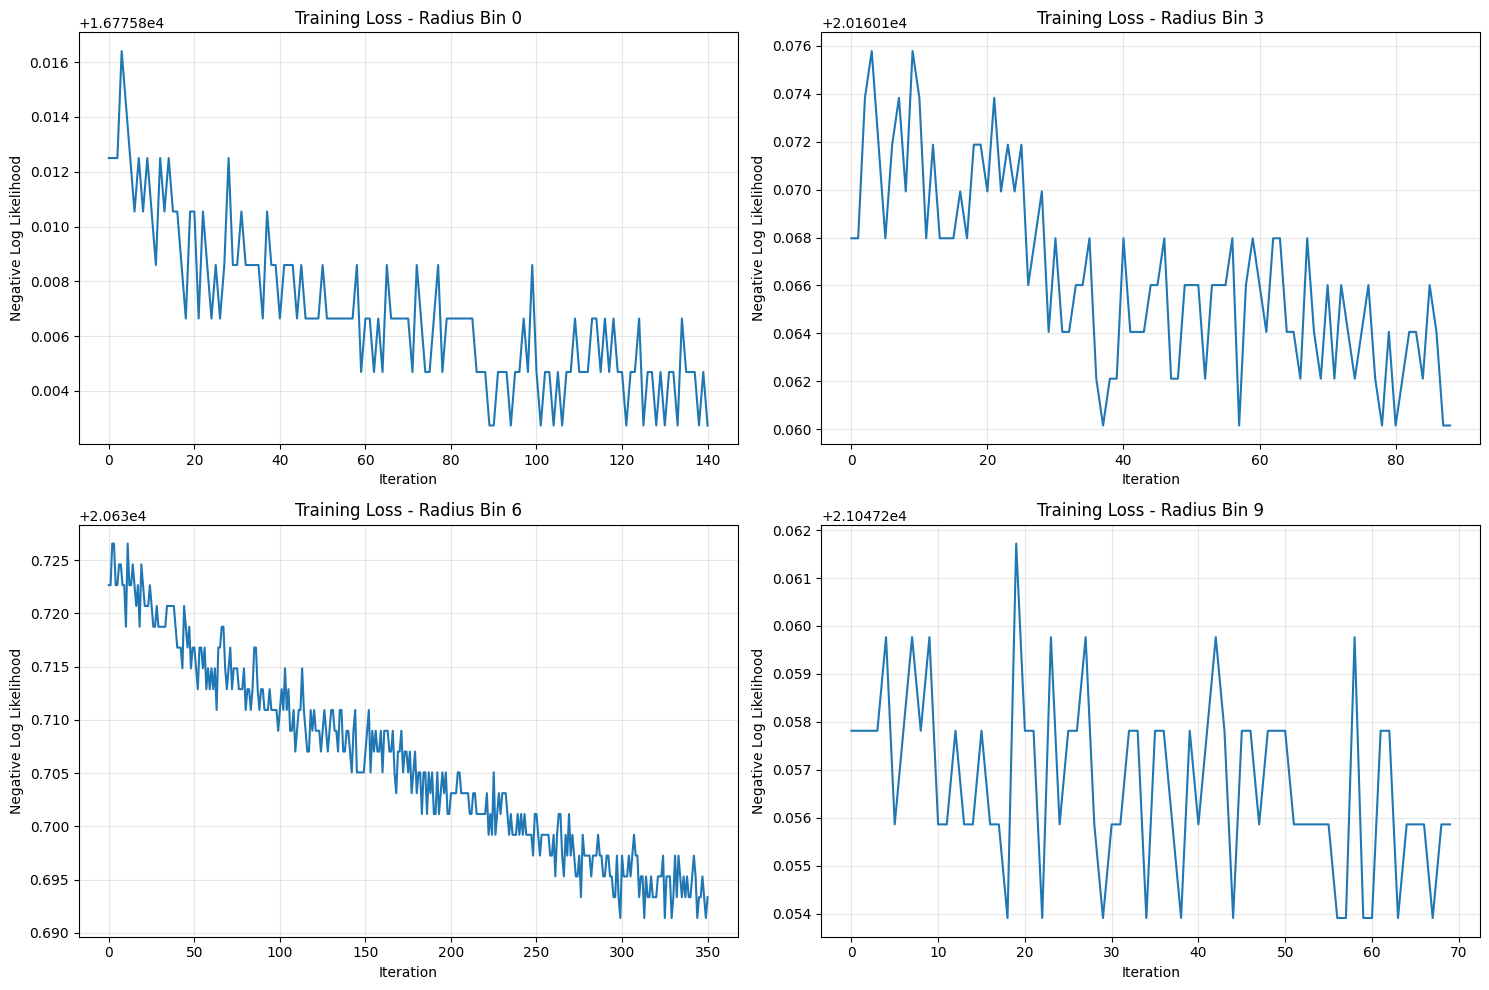

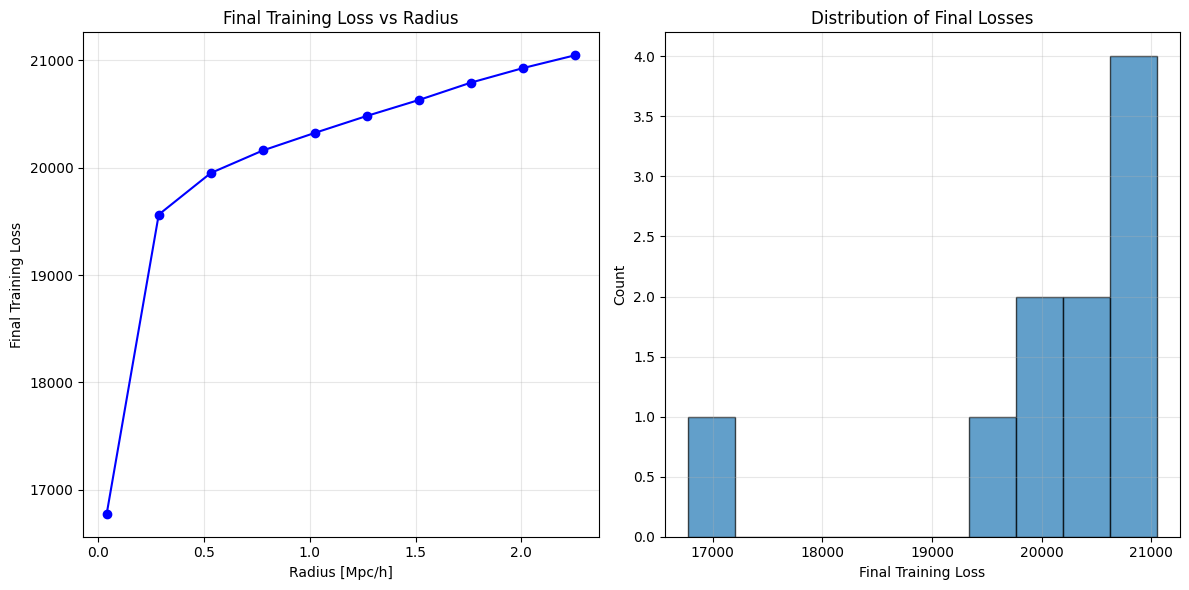

Models saved to /pscratch/sd/l/lindajin/DH_profile_kSZ_WL/trained_gp_models/GPTrainer_090925_1822_CAP_gas/

=== Testing GP Models ===


ValueError: Invalid mode or missing validation data.

In [4]:
# Train GP models
trainer.train(kernel_type='physics_informed', maxiter=1000, plot=True)
# Evaluate on test set
trainer.test(plot=True)

sim_indices_test = np.load('data/sparse_sampling_test_indices_random.npy')[:n_sims]  # Use subset for testing
X_test, y_test, _, _ = prepare_gp_training_data(sim_indices_test, filterType, ptype)
# Predict on new data
pred_means, pred_vars = trainer.pred(X_test)

In [ ]:
tuning_results = trainer.tune_hyperparameters(
      subset_ratio=0.1,  # 10% of data
      lr_candidates=[1e-4, 3e-4, 1e-3, 3e-3],
      kernel_types=['hierarchical', 'robust', 'physics_informed'],
      max_iter_tune=500,
      n_radius_bins_tune=5
  )

  # Get best config and train full model
best_config = tuning_results['best_config']